# Sklearn: Dimensional Reduction
Generalization refers to the property of a good dataset that has several observations for each combination of feature values. [Curse of dimensionality] is a phenomenom arises in a high dimensional dataset, where the number of possible values is very huge so that the dataset fails to *generalize*.

Imagine there are 10 *binary* features, then we need thousands of observations to generalize about 1000 combinations ($2^{10}=1024$). It's not hard to see that: to construct a good dataset, we are going to need millions of observations for 20 features and billions of observations for 30 features. Of course, a lot of combinations in real world data never exist, making the actual number of combinations is much smaller. However, the data size required still grows exponentially, thus this example still provides a good explanation of how dimensionality curses us.

The most challenging part in Machine Learning is to select the right set of features before traning any model. Irrelevant features may hurt the performance of our predictive model while they spend computing resources. Noises these features add to the dataset lead to overfitting and increase both training and predicting time. Thus, dimensionality reduction is an important task of Data Scientists.

[Curse of dimensionality]: https://en.wikipedia.org/wiki/Curse_of_dimensionality

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.selection import SelectByShuffling
from feature_engine.selection import DropCorrelatedFeatures
from feature_engine.selection import SmartCorrelatedSelection
from nni.algorithms.feature_engineering.gradient_selector import FeatureGradientSelector

from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, r_regression
from umap import UMAP

np.set_printoptions(precision=4, suppress=True)
warnings.filterwarnings('ignore')
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

## 1. Feature selection
Feature selection refers to the tasks that remove low quality data, hence keep informative features. It helps reduce noises and computational cost. Here are some feature selection techniques, they can be implemented very easily.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [2]:
dfMobile = pd.read_csv('../data/train_mobile_price.csv')
dfMobile = dfMobile.rename(columns={'priceRange':'target'})

x = dfMobile.drop(columns='target')
y = dfMobile['target']

dfMobile.head()

batteryPower  bluetooth  clockSpeed  dualSim  frontCam  4g  intMem  mDepth  \
0           842          0         2.2        0         1   0       7     0.6   
1          1021          1         0.5        1         0   1      53     0.7   
2           563          1         0.5        1         2   1      41     0.9   
3           615          1         2.5        0         0   0      10     0.8   
4          1821          1         1.2        0        13   1      44     0.6   

   mWeight  nCores  ...  pxHeight  pxWidth   ram  scrHeight  scrWidth  \
0      188       2  ...        20      756  2549          9         7   
1      136       3  ...       905     1988  2631         17         3   
2      145       5  ...      1263     1716  2603         11         2   
3      131       6  ...      1216     1786  2769         16         8   
4      141       2  ...      1208     1212  1411          8         2   

   talkTime  3g  touchScreen  wifi  target  
0        19   0            0     1       1  
1         7   1            1     0       2  
2         9   1            1     0       2  
3        11   1            0     0       2  
4        15   1            1     0       1  

[5 rows x 21 columns]

### 1.1. Filter methods
Filter methods rely on descriptive statistics of features to decide which one to be filtered out. They are done independently to Machine Learning algorithms, and are classified into three approaches:
- *Univariate statistics*. Methods of this type usually assess quality of features such as ratio of missing data or variance.
- *Feature interaction*. This approach analyzes feature pairs to examine if they bring the same information.
- *Target interaction*. The idea of this technique is scoring how strong the relationship between each feature and the target is.

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from feature_engine.selection import SelectByShuffling
from feature_engine.selection import DropCorrelatedFeatures
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, r_regression
from nni.algorithms.feature_engineering.gradient_selector import FeatureGradientSelector

#### Low variance filtering
Think about a constant feature, whose all observations have the same value, it has no predictive power and cannot explain the target variable. Therefore, features with very low variance can be safely removed. Implemented via Scikit-learn's
[`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html).

In [88]:
selector = VarianceThreshold(threshold=0.5)
selector.fit_transform(x)

array([[ 842. ,    2.2,    1. , ...,    9. ,    7. ,   19. ],
       [1021. ,    0.5,    0. , ...,   17. ,    3. ,    7. ],
       [ 563. ,    0.5,    2. , ...,   11. ,    2. ,    9. ],
       ...,
       [1911. ,    0.9,    1. , ...,    9. ,    1. ,    5. ],
       [1512. ,    0.9,    4. , ...,   18. ,   10. ,   19. ],
       [ 510. ,    2. ,    5. , ...,   19. ,    4. ,    2. ]])

In [89]:
selector.get_feature_names_out()

array(['batteryPower', 'clockSpeed', 'frontCam', 'intMem', 'mWeight',
       'nCores', 'primeCam', 'pxHeight', 'pxWidth', 'ram', 'scrHeight',
       'scrWidth', 'talkTime'], dtype=object)

#### Collinearity filtering
A pair of features having a high Pearson's correlation coefficient means they are very similar to each other, and they will bring the same information to the predictive model. Such a situation is called [collinearity], and it can mislead some Machine Learning algorithms. Therefore, only one variable in the highly correlated group should be used. This method is implemented in Feature-engine via the class
[`DropCorrelatedFeatures`](https://feature-engine.readthedocs.io/en/latest/api_doc/selection/DropCorrelatedFeatures.html)
, which only keeps the first high correlated feature.

[collinearity]: https://en.wikipedia.org/wiki/Multicollinearity

In [80]:
def plotCollinear(df, threshold=0.8, method='pearson'):
    matCorr = df.corr(method=method)
    maskCollinear = matCorr[matCorr > threshold].dropna(thresh=2).index
    matCorr = matCorr.loc[maskCollinear, maskCollinear]
    
    figsize = np.array(matCorr.shape) * 0.7
    palette = sns.diverging_palette(20, 220, as_cmap=True)
    plt.figure(figsize=figsize)
    sns.heatmap(matCorr, square=True, cmap=palette, vmin=-1, vmax=1, mask=np.triu(matCorr))
    plt.show()

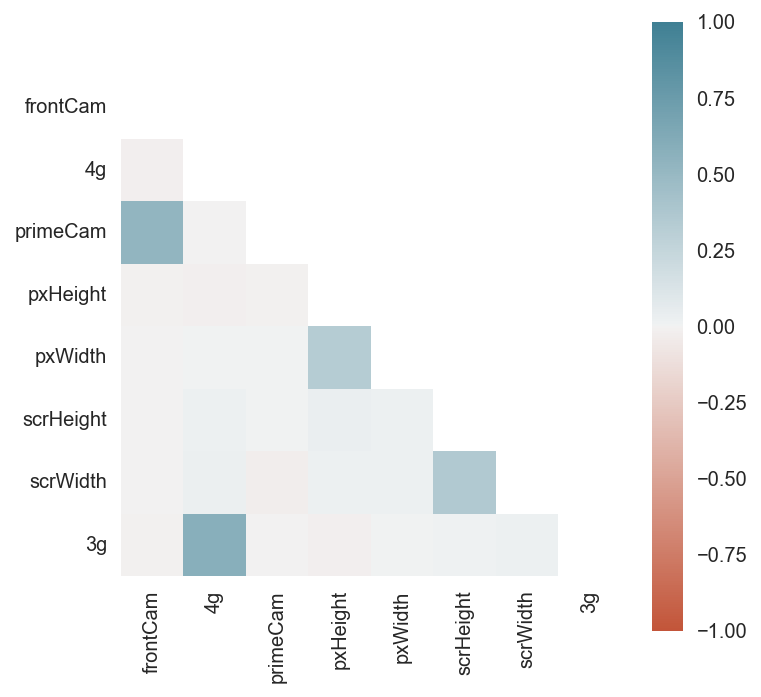

In [103]:
plotCollinear(x, 0.3, 'kendall')

In [105]:
selector = DropCorrelatedFeatures(method='pearson', threshold=0.3)
selector.fit_transform(x).head(3)

batteryPower  bluetooth  clockSpeed  dualSim  frontCam  4g  intMem  mDepth  \
0           842          0         2.2        0         1   0       7     0.6   
1          1021          1         0.5        1         0   1      53     0.7   
2           563          1         0.5        1         2   1      41     0.9   

   mWeight  nCores  pxHeight   ram  scrHeight  talkTime  touchScreen  wifi  
0      188       2        20  2549          9        19            0     1  
1      136       3       905  2631         17         7            1     0  
2      145       5      1263  2603         11         9            1     0

In [87]:
selector.correlated_feature_sets_

[{'frontCam', 'primeCam'},
 {'3g', '4g'},
 {'pxHeight', 'pxWidth'},
 {'scrHeight', 'scrWidth'}]

Feature-engine also provides a synthetic class
[`SmartCorrelatedSelection`](https://feature-engine.readthedocs.io/en/latest/api_doc/selection/SmartCorrelatedSelection.html)
that integrates multiple selection techniques at once: missing data, variance, collinearity and model-based.

In [92]:
selector = SmartCorrelatedSelection(selection_method='missing_values', threshold=0.6)
selector.fit_transform(x).head(3)

batteryPower  bluetooth  clockSpeed  dualSim  frontCam  4g  intMem  mDepth  \
0           842          0         2.2        0         1   0       7     0.6   
1          1021          1         0.5        1         0   1      53     0.7   
2           563          1         0.5        1         2   1      41     0.9   

   mWeight  nCores  pxHeight  pxWidth   ram  scrHeight  scrWidth  talkTime  \
0      188       2        20      756  2549          9         7        19   
1      136       3       905     1988  2631         17         3         7   
2      145       5      1263     1716  2603         11         2         9   

   3g  touchScreen  wifi  
0   0            0     1  
1   1            1     0  
2   1            1     0

#### Target-based selection
Another strategy is [univariate feature selection], it measures the relationship between each feature and the target, then select best scored features. It is implemented in Scikit-learn's via the class
[`GenericUnivariateSelect`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html).
The scoring function can be choosen among:
- Pearson's correlation coefficient
- ANOVA F-value
- Chi-squared test statistic
- [Mutual information], a metric can show non-linear relationship

[univariate feature selection]: https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
[Mutual information]: https://en.wikipedia.org/wiki/Mutual_information

In [95]:
selector = GenericUnivariateSelect(score_func=f_classif, mode='percentile', param=20)
selector.fit_transform(x, y)
selector.get_feature_names_out()

array(['batteryPower', 'pxHeight', 'pxWidth', 'ram'], dtype=object)

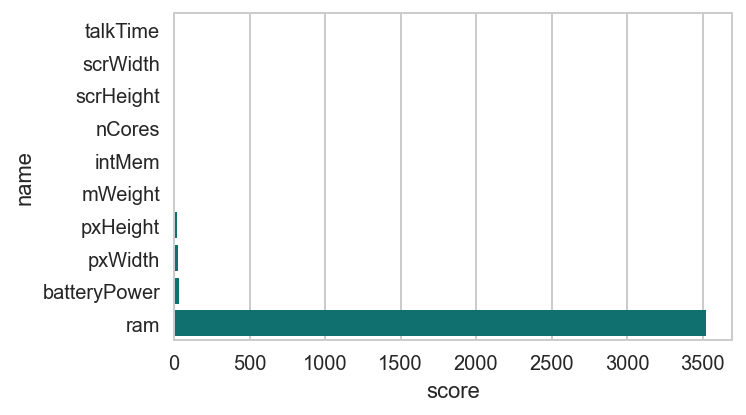

In [99]:
nTop = 10

df = pd.DataFrame({'name': selector.feature_names_in_, 'score': selector.scores_})
df = df.sort_values('score')
df = df.query("score > 0")
df = df.tail(nTop)

fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(data=df, x='score', y='name', color='teal')
plt.show()

#### Gradient selection
NNI's [`GradientFeatureSelector`](https://nni.readthedocs.io/en/stable/feature_engineering/gradient_feature_selector.html)
is a cool algorithm with low computational complexity, high statistical efficiency that can detect higher-order feature interations for large datasets.

In [101]:
selector = FeatureGradientSelector(n_features=10)
selector.fit_transform(x, y).head()

batteryPower  4g  intMem  nCores  pxWidth   ram  scrHeight  talkTime  3g  \
0           842   0       7       2      756  2549          9        19   0   
1          1021   1      53       3     1988  2631         17         7   1   
2           563   1      41       5     1716  2603         11         9   1   
3           615   0      10       6     1786  2769         16        11   1   
4          1821   1      44       2     1212  1411          8        15   1   

   wifi  
0     1  
1     0  
2     0  
3     0  
4     0

### 1.2. Model-based methods
Also known as wrapper methods, they run Machine Learning algorithms on the dataset to detect unimporatant features. This strategy is considered more accurate but more expensive that filter methods. It also depends on the quality of the model used in the process.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE, RFECV
from feature_engine.selection import SelectByShuffling

#### Greedy elimination
This method can be used in two directions: bottom-up (foward addition) or top-down (backward elimination). While considering a subset of features, it tries to add the best feature or to remove the worst feature based on cross-validated score. The process is repeated util the desired number of feature is reached. This technique is implemented via Scikit-learn's
[`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html),
but should never be used in practice due to the huge number of models need to be trained.

In [111]:
estimator = DecisionTreeClassifier(max_depth=4)
selector = SequentialFeatureSelector(
    estimator, 
    direction='forward', 
    n_features_to_select=5,
    scoring='accuracy'
)

selector = selector.fit(x, y)
selector.get_feature_names_out()

array(['batteryPower', 'bluetooth', 'clockSpeed', 'pxHeight', 'ram'],
      dtype=object)

#### Importance analysis
Some Machine Learning algorithms have the ability to return feature importances. For example, Linear Regression uses variable weights and Decision Tree uses information gains. Feature importances express how much information features contribute on predicting the target variable. We can take advantage of it to remove low important features. This selector can be found in Scikit-learn's class
[`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)

Importance analysis only requires a single model to be trained, thus it is not very expensive. But you should consider feature importances with a grain of salt, as it does not always resemble the true contribution.

In [13]:
estimator = DecisionTreeClassifier(max_depth=4)
selector = SelectFromModel(estimator, max_features=10)
selector.fit_transform(x, y)

array([[ 842., 2549.],
       [1021., 2631.],
       [ 563., 2603.],
       ...,
       [1911., 3057.],
       [1512.,  869.],
       [ 510., 3919.]])

In [8]:
selector.get_feature_names_out()

array(['batteryPower', 'ram'], dtype=object)

#### Ranked elimination
This selector is Scikit-learn's combines greedy elimination with importance analysis and takes the best of both worlds. It firstly trains a model using all features, prunes worst scoring ones based on feature importances, then trains a new model using current subset, measures the importances again,... The process is repeated until the desired number of features is reached. The implementations of this method is found in Sckit-learn via the classes
[`RFE`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) and
[`RFECV`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html).

There are some differences compared to the greedy method above. First, as we need to update feature importances at each iteration, bottom-up approach will not be used. Second, ranked elimination can discard more than one feature at a time, which significantly reduce the number of iterations required.

In [11]:
estimator = DecisionTreeClassifier(max_depth=4)
seletor = RFE(estimator, n_features_to_select=10, step=1)
seletor = seletor.fit(x, y)

seletor.get_feature_names_out()

array(['batteryPower', 'mDepth', 'pxHeight', 'pxWidth', 'ram',
       'scrHeight', 'scrWidth', 'talkTime', '3g', 'touchScreen'],
      dtype=object)

#### Stochastic prediction
Ranked elimiation is much faster than greedy elimiation, but it is still not enough to be popular in practical tasks. When talking about a Machine Learning model, notice that the predicting time is much less than the training time. A smart approach has been proposed to take advantage of this, it is implemented via Feature-engine's
[`SelectByShuffling`](https://feature-engine.readthedocs.io/en/latest/api_doc/selection/SelectByShuffling.html).

This technique first trains a model on the entire feature set, then measures performance drop when predicting when each feature is random shuffled. If a feature is importance, the model will witness a significant performance drop when that feature is shuffled. Stochastic prediction trains only once, and thus is much faster than elimination methods.

In [20]:
selector = SelectByShuffling(
    estimator=DecisionTreeClassifier(max_depth=4),
    scoring='roc_auc_ovr', cv=3,
    threshold=0.01
)
selector.fit_transform(x, y).head()

batteryPower  pxHeight   ram
0           842        20  2549
1          1021       905  2631
2           563      1263  2603
3           615      1216  2769
4          1821      1208  1411

## 2. PCA
[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (Principle Component Analysis) is a very popular dimensionality reduction aiming to construct a new dataset having less dimensions but retains most important characteristics of the original dataset. The term *characteristic* is defined by PCA using *variance*, which means we project data so that the variance of the image is maximized. To achieve this, PCA constructs a new coordinate system, in which each axis is found so that it (1) is orthorgonal to all previous axes and (2) maximizes the variance of its image.

### 2.1  Algorithm
*Input*: A dataset having $D$ variables $\mathbf{X}=(\mathbf{x}_1,\mathbf{x}_2,\dots,\mathbf{x}_D)\in\mathbb{R}^{N\times D}$ and the number of components you expect to keep, $K$.

*Step 1*. Standardize all variables so that they are on the same scale. Then compute the covariance matrix $\mathbf{Q}\in\mathbb{R}^{D\times D}$ of the scaled variables, notice that this is a symmetric square matrix.

*Step 2*. Solve for the eigenvalues $(\lambda_1,\lambda_2,\dots,\lambda_D)$ and eigenvectors $(\mathbf{u}_1,\mathbf{u}_2,\dots,\mathbf{u}_D)$ of $\mathbf{Q}$. As the covariance matrix is symmetric, all their eigenvectors are orthogonal.

*Step 3*. Choose $K$ eigenvectors with largest eigenvalues and construct a matrix $\mathbf{W}=(\mathbf{u}_1,\mathbf{u}_2,\dots,\mathbf{u}_K)$. Notice $\mathbf{u}_k\in\mathbb{R}^{D}$, then $\mathbf{W}\in\mathbb{R}^{D\times K}$. The orthogonality of eigenvectors makes $\mathbf{W}$ a set of axes and form a new coordinate system.

*Step 4*. Project original data to the new coordinate system by computing $\mathbf{X}'=\mathbf{X}\mathbf{W}$. It turns out, the variations each new axis accounts for is quantified by the corresponding eigenvalue. Thus, $K$ eigenvectors selected in step 3 are the most important components. An effective PCA model should have most variations explained in a few first components.

### 2.2. Implementation
PCA is implemented in Scikit-learn via the classes [`PCA`] (original version), [`KernelPCA`] (non-linear reduction) and [`IncrementalPCA`] (mini-batch processing). They all have a main hyperparameter:
- `n_components`: the number of principal components to keep, defaults to *None* (keep all components). It can accept (1) an integer for the number of components, (2) a float in the range $(0,1)$ for a minimum threshold that total percentage of explained variances must be greater that, or (3) *mle* for letting PCA guess the dimension. The number of components in PCA can be determined using a scree plot.

[`PCA`]: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
[`KernelPCA`]: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html 
[`IncrementalPCA`]: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [4]:
dfIris = pd.read_csv('../data/iris.csv')
dfIris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [5]:
x = dfIris.drop(columns='species')
y = dfIris.species

reducer = PCA(n_components=None)
reducer = reducer.fit(x)

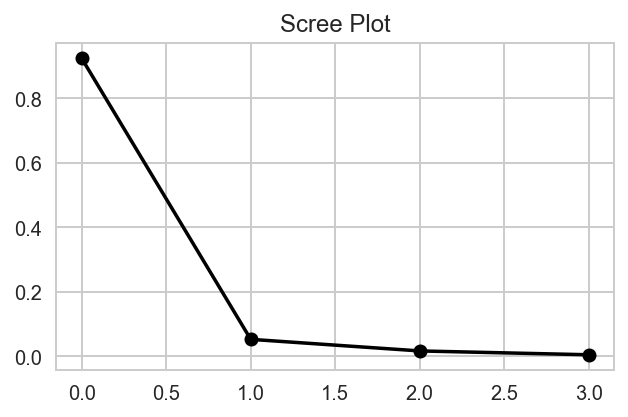

In [6]:
variances = reducer.explained_variance_ratio_
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(variances, '-ok')
ax.set_title('Scree Plot')
plt.show()

In [10]:
# eigenvectors
reducer.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143],
       [-0.31548719,  0.3197231 ,  0.47983899, -0.75365743]])

Looking at the scree plot, the explained variances drops significantly right after the first component (PC1). This means, we only need to keep PC1, as it's very good at retaining the most characteristics of the Iris dataset. PC1 is constructed by:

$$\text{PC1}=0.36\cdot\text{sepalLength}-0.08\cdot\text{sepalWidth}+0.85\cdot\text{petalLength}+0.35\cdot\text{petalWidth}$$

To further verify the performance of PC1, we color each flower by its species (this field was not used in training PCA).

In [7]:
xTransformed = reducer.transform(x)
pcNames = [f'PC{i+1}' for i in range(xTransformed.shape[1])]
xTransformed = pd.DataFrame(xTransformed, columns=pcNames)
xTransformed.head()

PC1       PC2       PC3       PC4
0 -2.684126  0.319397 -0.027915 -0.002262
1 -2.714142 -0.177001 -0.210464 -0.099027
2 -2.888991 -0.144949  0.017900 -0.019968
3 -2.745343 -0.318299  0.031559  0.075576
4 -2.728717  0.326755  0.090079  0.061259

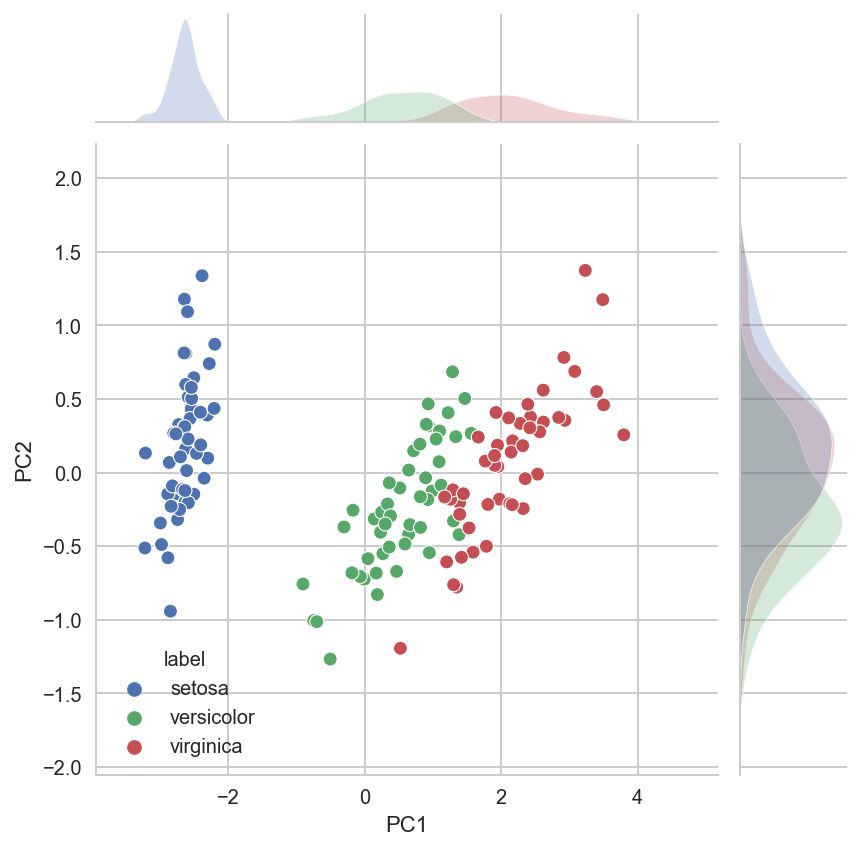

In [8]:
dfTransformed = xTransformed.assign(label=y)
sns.jointplot(data=dfTransformed, x='PC1', y='PC2', hue='label', marginal_kws={'edgecolor':'w'})
plt.show()

## 3. LDA
[LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) (Linear Discriminant Analysis) is a supervised dimensionality reduction algorithm. Its ultimate goal is to map data to a new space so that classes are most *discriminant*, which can be achieved via (1) maximizing between-class variances and (2) minimizing within-class variances.

### 3.1. Algorithm
LDA can be performed in various ways, where a simple method is applying eigendecomposition.

*Input*:
- A dataset of size $N\times D$, divided into $M$ classes: $\mathcal{C}_1,\mathcal{C}_2,\dots,\mathcal{C}_M$
- The number of components you expect to keep, $K$
- Notation:
    - $\mathbf{s}_i$ is the index of an observation belongs to a class
    - $\bar{\mathbf{s}}_m$ is the mean vector of class $\mathcal{C}_m$
    - $\bar{\mathbf{s}}$ is the overall mean vector

*Step 1*: Compute the within-class scatter matrix, $\mathbf{S}_\text{W}\in\mathbb{R}^{D\times D}$, by taking the sum of scatter matrices of all classes.

$$\mathbf{S}_\text{W}=\sum_{m=1}^{M}\sum_{\mathbf{s}_i\in\mathcal{C}_m}^{}{(\mathbf{s}_i-\bar{\mathbf{s}}_m)(\mathbf{s}_i-\bar{\mathbf{s}}_m)^\text{T}}$$

*Step 2*: Compute the between-class scatter matrix, $\mathbf{S}_\text{B}\in\mathbb{R}^{D\times D}$

$$\mathbf{S}_\text{B}=\sum_{m=1}^{M}{N_m}(\bar{\mathbf{s}}_m-\bar{\mathbf{s}})(\bar{\mathbf{s}}_m-\bar{\mathbf{s}})^\text{T}$$

*Step 3*: Solve the generalized eigenvalue problem for $\mathbf{S}_\text{W}^{-1}\mathbf{S}_\text{B}$ to obtain its eigenvalues $(\lambda_1,\lambda_2,\dots,\lambda_D)$ and eigenvectors $(\mathbf{u}_1,\mathbf{u}_2,\dots,\mathbf{u}_D)$.

*Step 4*. Choose $K$ eigenvectors with largest eigenvalues and construct a transformation matrix $\mathbf{W}=(\mathbf{u}_1,\mathbf{u}_2,\dots,\mathbf{u}_K)$ of new axes. Then project original data to the new coordinate system by computing $\mathbf{X}'=\mathbf{X}\mathbf{W}$. Recall steps 3 and 4 of PCA.

### 3.2. Implementation
Scikit-learn implements LDA and QDA via the classes [`LinearDiscriminantAnalysis`] and [`QuadraticDiscriminantAnalysis`]. They have only one hyperparameter like PCA:
- `n_components`: the number of principal components to keep, defaults to *None* (keep all components).

[`LinearDiscriminantAnalysis`]: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
[`QuadraticDiscriminantAnalysis`]: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [12]:
dfIris = pd.read_csv('../data/iris.csv')
x = dfIris.drop(columns='species')
y = dfIris.species
dfIris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [25]:
reducer = LDA(n_components=None)
reducer = reducer.fit(x, y)

In [16]:
reducer.explained_variance_ratio_

array([0.9912126, 0.0087874])

In [27]:
xTransformed = reducer.transform(x)
ldNames = [f'LD{i+1}' for i in range(xTransformed.shape[1])]
xTransformed = pd.DataFrame(xTransformed, columns=ldNames)
xTransformed.head()

LD1       LD2
0  8.061800  0.300421
1  7.128688 -0.786660
2  7.489828 -0.265384
3  6.813201 -0.670631
4  8.132309  0.514463

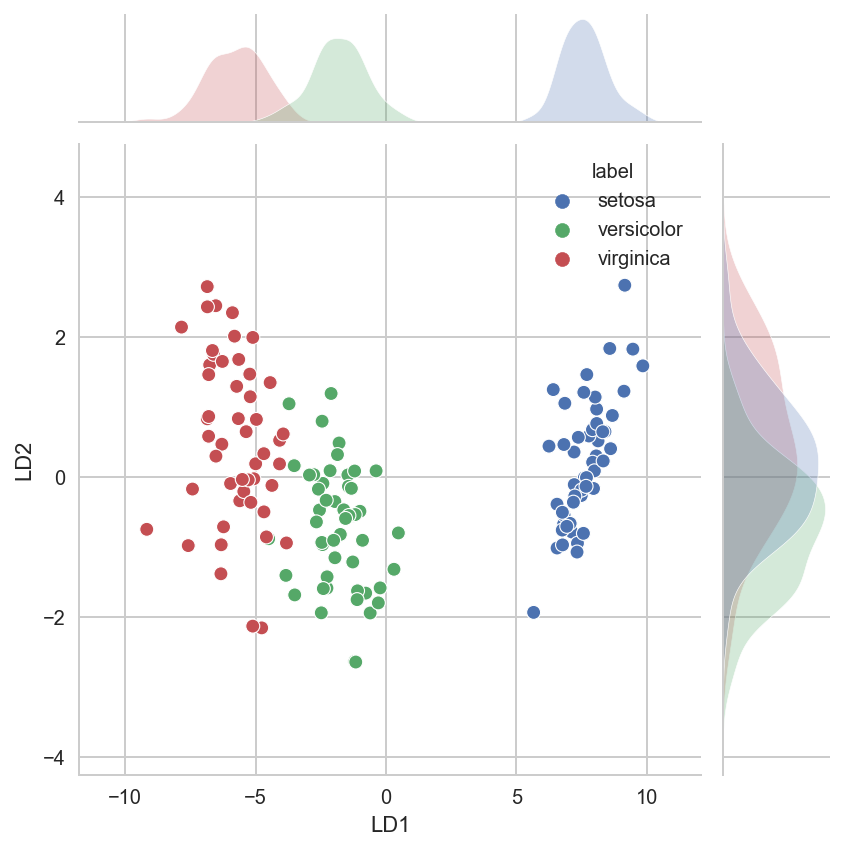

In [28]:
dfTransformed = xTransformed.assign(label=y)
sns.jointplot(data=dfTransformed, x='LD1', y='LD2', hue='label', marginal_kws={'edgecolor':'w'})
plt.show()

## 4. t-SNE
[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-distributed Stochastic Neighbor Embedding) is an algorithm of manifold learning, a family of methods trying to represent *non-linear* structure in data. Introduced in 2008, t-SNE quickly becomes popular in discovering characteristics of data, as the algorithm has the ability to embed any high-dimensional dataset into 2 or 3 embedded vectors, which is friendly to human.

Despite its popularity, t-SNE has some drawbacks:
- It is computationally expensive and does not scale very well.
- It does not preserve global data structure, specifically, between-cluster variances are not meaningful.
- The result is not deterministic (due to stochastic intialization); different runs may give different results.
- It's hard to select an optimal value of perplexity.

### 4.1. Algorithm
*Input:* A dataset having $N$ observations $\mathbf{X}=\mathbf{s}_1,\mathbf{s}_2,\dots,\mathbf{s}_N$ and the perplexity $K$, the number of effective neighbors around a point.

*Step 1.* Compute high-dimensional affinities using different normal distributions. These distributions locate at data points (which gives us $\mu$) and are more center-concentrated in denser regions (which gives us $\sigma$).
- For each data point $\mathbf{s}_n$, perform a binary search for $\sigma_n$ such that the [entropy] of the distribution $\text{N}(\mathbf{s}_n,\sigma_n)$ over neighbors equals to $\log_2K$
- Calculate the *asymmetric* similarity between $\mathbf{s}_n$ and each of its neighbor $\mathbf{s}_m$ equals to the probability density at $\mathbf{s}_m$ (note that $\phi_{m|n}\neq \phi_{n|m}$). As the similarity will be normalized later, the coeficient will be canceled out and is not include in the formula. We also set $\phi_{n|n}=0$.

$$\phi_{m|n}=\exp{\left(\frac{\|\mathbf{s}_n-\mathbf{s}_m\|_2^2}{\sigma_n}\right)}$$

- Normalize $\phi_{m|n}$ to get the affinity $p_{m|n}$. It represents the probability that a point $\mathbf{s}_m$ becomes an effective neighbor of $\mathbf{s}_n$.

$$p_{m|n}=\phi_{m|n}\div\sum_{m=1}^{N}{\phi_{m|n}}$$

*Step 2.* Symmetrize high-demensional affinities. This makes the computation needed for step 4 much more simpler. The formula ensure every point has a significant contribution to the cost function:

$$p_{mn}=\frac{p_{m|n}+p_{n|m}}{2N}$$

*Step 3.* Construct formulation for low-dimensional affinities. We first denote $\mathbf{s}'_1,\mathbf{s}'_2,\dots,\mathbf{s}'_N$ the images in low dimension, which are unknown. This step uses a t-distribution with 1 degree of freedom ($\nu=1$), which has a heavier tail than a normal distribution. This has proved in practice its efficiency.

$$\begin{aligned}
\phi'_{mn} &= \left(1+\|\mathbf{s}'_n-\mathbf{s}'_m\|_2^2\right)^{-1} \\
p'_{mn} &= \phi'_{mn}\div\sum_{n=1}^{N}\sum_{m=1}^{N}\phi'_{mn}
\end{aligned}$$

*Step 4.* Find optimal value for $\mathbf{X}'$ using *Gradient Descent (with momentum)* that minimizes Kullback-Leibler divergences:

$$\mathcal{L}(\mathbf{X}')=\sum_{n=1}^{N}\sum_{m=1}^{N}{p_{mn}\log{\frac{p_{mn}}{p'_{mn}}}}$$

[entropy]: https://en.wikipedia.org/wiki/Entropy_(information_theory)

### 4.2. Implementation
Scikit-learn implements t-SNE via the classes
[`TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).
It has the following hyperparameters:
- `n_components`: the dimension of the space to embed into, defaults to *2*.
- `perplexity`: the number of effective neighbors, defaults to *30*. Should be greater on large datasets.
- `early_exaggeration`: a parmater controls the space between natural cluster in the embedding space, defaults to *12*.
- `n_iter`: the number of iteration in Gradient Descent, defaults to *1000*.
- `learning_rate`: the learning rate in Gradient Descent, defaults to *200*. Can be set to other floats or *auto*.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

import warnings; warnings.filterwarnings('ignore')

In [2]:
dfIris = pd.read_csv('../data/iris.csv')
x = dfIris.drop(columns='species')
y = dfIris.species
dfIris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [18]:
reducer = TSNE(n_components=2, perplexity=10)
xTransformed = reducer.fit_transform(x)
ldNames = [f'EV{i+1}' for i in range(xTransformed.shape[1])]
xTransformed = pd.DataFrame(xTransformed, columns=ldNames)
xTransformed.head()

EV1        EV2
0 -18.720890 -35.738895
1 -25.321299 -27.586557
2 -25.457335 -24.214565
3 -23.622675 -24.388340
4 -20.159002 -37.195858

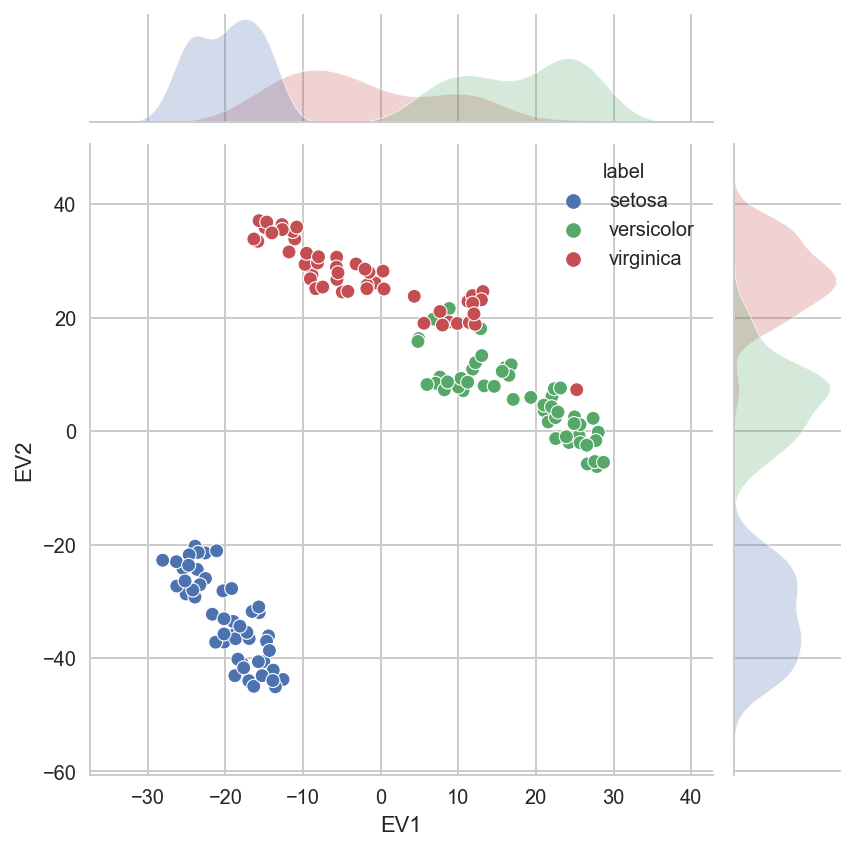

In [22]:
dfTransformed = xTransformed.assign(label=y)
sns.jointplot(data=dfTransformed, x='EV1', y='EV2', hue='label', marginal_kws={'edgecolor':'w'})
plt.show()

## 5. UMAP
[Uniform Manifold Approximation and Projection](https://arxiv.org/abs/1802.03426) (UMAP) is another algorithm of the neighbor embedding family, coming with a lot of improvements to solve the problems that t-SNE (as well as other implementations of it) suffers from.
- UMAP is capable of capturing global structure of the dataset
- UMAP can practically embed data to more than 3 dimensions
- UMAP improves dramatically in time consuming when compared to t-SNE

### 5.1. Algorithm
In this section, we are only going to review the differences between UMAP and t-SNE and analyze how these changes affect their outputs.

- In step 1 of t-SNE, UMAP uses a different equation to calculate $\phi_{m|n}$, in which $d(\mathbf{s}_m,\mathbf{s}_n)$ is any distance metric (not limited to Euclidean) and $\rho_n$ is the distance between $\mathbf{s}_n$ and its nearest neighbor. The occurance of $\rho_n$ gives an adaptive kernel for each data point.

$$\phi_{m|n}=\exp{\left(-\frac{d(\mathbf{s}_m,\mathbf{s}_n)^2-\rho_n}{\sigma_n}\right)}$$

- Also in step 1, UMAP does not normalize $\phi_{m|n}$. Thus, $p_{m|n}=\phi_{m|n}$. The absence of normalization in both computing $p_{m|n}$ and $p'_{m|n}$ significantly reduces the computation time of UMAP, especially for large datasets.

- In step 2, UMAP designs a slightly different equation for symmetrization of high-dimensional affinities:

$$p_{mn}=p_{m|n}+p_{n|m}-p_{m|n}p_{n|m}$$

- In step 3, UMAP use a more generalized equation for computing low-dimensional affinities, which is a family of curves parameterized by $a$ and $b$. These parameters are estimated by UMAP, and adapts from point to point in low-dimensional space.

$$\phi'_{mn}=p'_{mn}=\left(1+a\cdot d(\mathbf{s}_m,\mathbf{s}_n)^{2b}\right)^{-1}$$

- In step 4, UMAP uses a Cross Entropy as the loss function instead of Kullback-Leibler divergences. This choice of loss function makes UMAP capable of preserving global data structure.

$$\mathcal{L}(\mathbf{X}')=
\sum_{n=1}^{N}\sum_{m=1}^{N} \left[
    p_{mn}\log{\frac{p_{mn}}{p'_{mn}}}+
    (1-p_{mn})\log{\frac{1-p_{mn}}{1-p'_{mn}}}
\right]
$$

- Also in step 4, UMAP initializes low-dimensional coordinates using Graph Lapacian instead of randomizing. This strategy makes UMAP results not change much after each run.

- Finally, still in step 4, UMAP implements Stochastic Gradient Descent. The benefits of SGD over normal GD have been proven by its success in Deep Learning.

### 5.2. Implementation
UMAP is implemented in its own [library](https://umap-learn.readthedocs.io/en/latest/index.html) via the class
[`UMAP`](https://umap-learn.readthedocs.io/en/latest/api.html). It has the following hyperparameters:
- `n_components`: the dimension of the space to embed into, defaults to *2*. Can increase up to 100.
- `n_neighbors`: the number of effective neighbors of each sample, defaults to *15*. Larger values result in more global views of the manifold, while smaller values result in more local data being preserved.
- `metric`: the distance metric used in high-dimensional data, defaults to *euclidean*. Can be other metric names in string or a custom function.
- `output_metric`: the distance metric used in low-dimensional data, defaults to *euclidean*.
- `min_dist`: the effective minimum distance between embedded points, defaults to *0.1*. Smaller values result in nearby points in the original dataset are embedded closer toghether.
- `spread`: the effective scale of embedded points, defaults to *1*. In combination with *min_dist* this determines how clustered/clumped the embedded points are.
- `n_epochs`: the number of epochs in SGD, defaults to *None* (UMAP's rule: 500 for small datasets and 200 for large datasets).
- `learning_rate`: the learning rate in SGD, defaults to *1*.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from umap import UMAP

import warnings; warnings.filterwarnings('ignore')

In [4]:
dfIris = pd.read_csv('../data/iris.csv')
x = dfIris.drop(columns='species')
y = dfIris.species
dfIris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [7]:
reducer = UMAP(n_components=2)
xTransformed = reducer.fit_transform(x)
ldNames = [f'EV{i+1}' for i in range(xTransformed.shape[1])]
xTransformed = pd.DataFrame(xTransformed, columns=ldNames)
xTransformed.head()

EV1        EV2
0  19.186245  13.658341
1  18.839174  11.648748
2  18.308769  12.255518
3  18.401110  11.946709
4  19.238541  13.426895

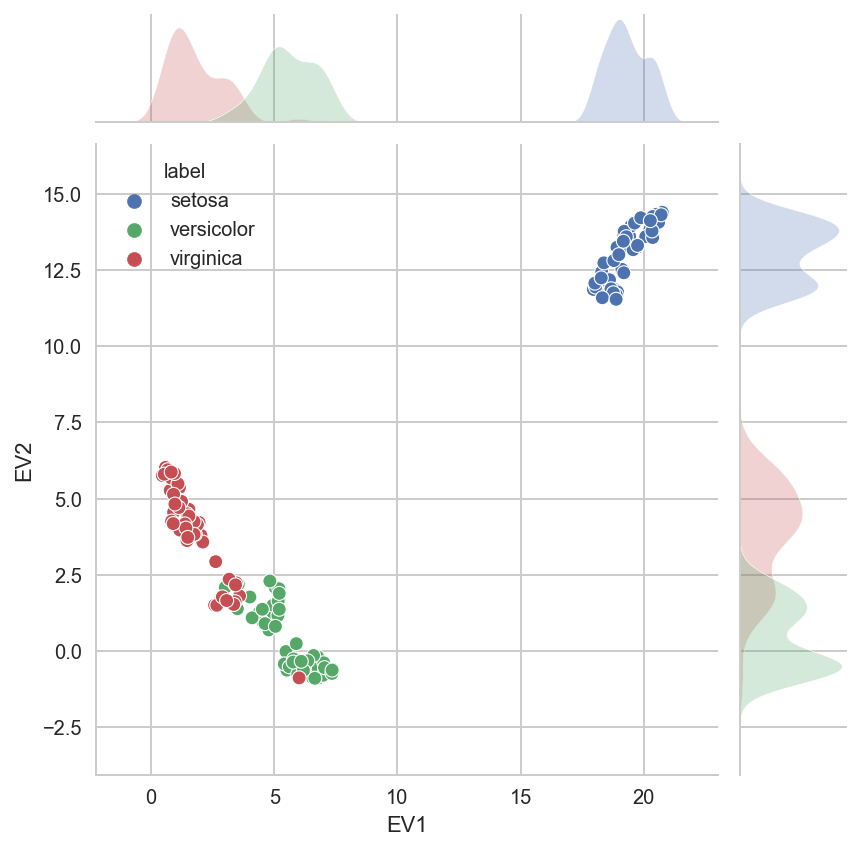

In [8]:
dfTransformed = xTransformed.assign(label=y)
sns.jointplot(data=dfTransformed, x='EV1', y='EV2', hue='label', marginal_kws={'edgecolor':'w'})
plt.show()

## Resources
- *cs.toronto - [Stochastic Neighbor Embedding](https://www.cs.toronto.edu/~hinton/absps/sne.pdf)*
- *jmlr - [Visualizing data using t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)*
- *medium - [How exactly UMAP works?](https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668)*
- *distill - [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)*
- *pair-code.github - [Understanding UMAP](https://pair-code.github.io/understanding-umap/)*
- *medium - [Which features to use in your model?](https://medium.com/@hertan06/which-features-to-use-in-your-model-350630a1e31c)*

## Install

In [ ]:
pip install --user nni
pip install --user torch
pip install --user feature_engi